# Project 1: Infrared Spectral Energy Distributions

In [2]:
# Date created: Oct 9, 2020

In [3]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import emcee
import corner
plt.ion()
plt.rcParams.update({'font.size': 16, 'text.usetex': True})

In [4]:
# constants

h = 6.626e-34 #[J*s]
k = 1.381e-23 #[J/K]


In [5]:
# functions

def limit(nu, T, alpha, beta):
    return 3 + beta - ((10**nu)*h/(k*T))*np.exp(h*(10**nu)/(k*T))/(np.exp(h*(10**nu)/(k*T))-1) + alpha

def model1(freq, fit):
    L, T, alpha, beta = fit
    nu_prime = optimize.newton(limit, 13, args=(T, alpha, beta))
    L1 = ((10**L)*(10**nu_prime)**(3+beta)/(np.exp(h*(10**nu_prime)/(k*T))-1)/((10**nu_prime)**(-1*alpha)))
    predictions = []
    
    for nu in freq:
        if (nu < 10**nu_prime):
            predictions.append( 1e-26*(10**L)*(nu**(3+beta))/(np.exp(h*nu/(k*T))-1) )
        else:
            predictions.append( 1e-26*L1*(nu**(-1*alpha)) )
    return predictions

def penalty(param, freq, flux, error):
    return np.sum((model1(freq, param)-flux)**2/error**2)

def lnprob(param, freq, flux, error):
     return -0.5*penalty(param, freq, flux, error)

# NGC 0958

<ipython-input-13-c8d4537c0a15>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


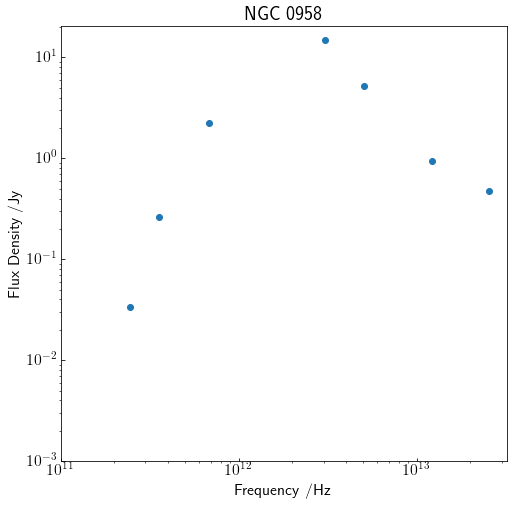

In [13]:
# hard code data, NGC 0958

frequencies_NGC = (1 + 0.019)*np.array([2.4e+11, 3.53e+11, 6.66e+11, 3e+12, 5e+12, 1.2e+13, 2.5e+13])
flux_densities_NGC = np.array([0.034, 0.262, 2.25, 14.99, 5.25, 0.94, 0.4735])
errors_NGC = np.array( [0.007, 0.034, 0.428, 0.212, 0.2625, 0.035, 0.0616] )

f, ax = plt.subplots(1, figsize=(8,8))
ax.plot(frequencies_NGC, flux_densities_NGC, 'o')
ax.set_xscale('log')
ax.set_xticks([1e+11, 1e+12, 1e+13])
ax.set_yscale('log')
ax.set_yticks([0.001, 0.01, 0.1, 1, 10])
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.set_title('NGC 0958')
ax.set_ylabel('Flux Density /Jy')
ax.set_xlabel('Frequency /Hz')
f.show()

Optimization terminated successfully.
         Current function value: 20.570935
         Iterations: 396
         Function evaluations: 678
[-41.48854068  16.58623614   1.97852595   2.80478096]


<ipython-input-14-fc79847eab0c>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


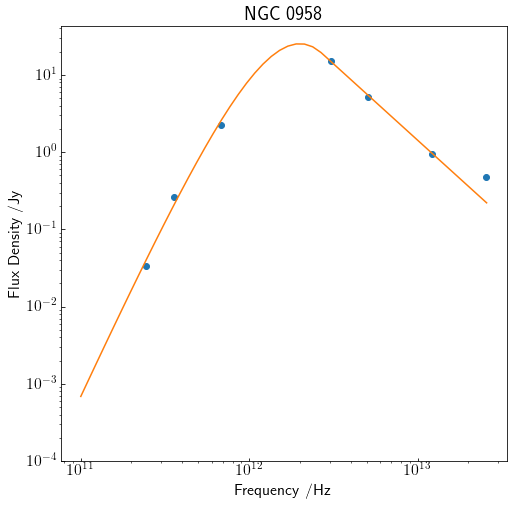

In [14]:
fit = optimize.fmin(penalty, [-32, 28.8, 2.02, 1.5], args=(frequencies_NGC, flux_densities_NGC, errors_NGC))
ngc_fit = model1(frequencies_NGC, fit)
print (fit)

#plot fit for NGC 09958
x = np.logspace(11,13.41000)

f, ax = plt.subplots(1, figsize=(8,8))
ax.plot(frequencies_NGC, flux_densities_NGC, 'o')
ax.plot(x, model1(x,fit))
ax.set_xscale('log')
ax.set_xticks([1e+11, 1e+12, 1e+13])
ax.set_yscale('log')
ax.set_yticks([0.0001, 0.001, 0.01, 0.1, 1, 10])
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.set_title('NGC 0958')
ax.set_ylabel('Flux Density /Jy')
ax.set_xlabel('Frequency /Hz')
f.show()

<ipython-input-181-d52d01e634d7>:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
<ipython-input-181-d52d01e634d7>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


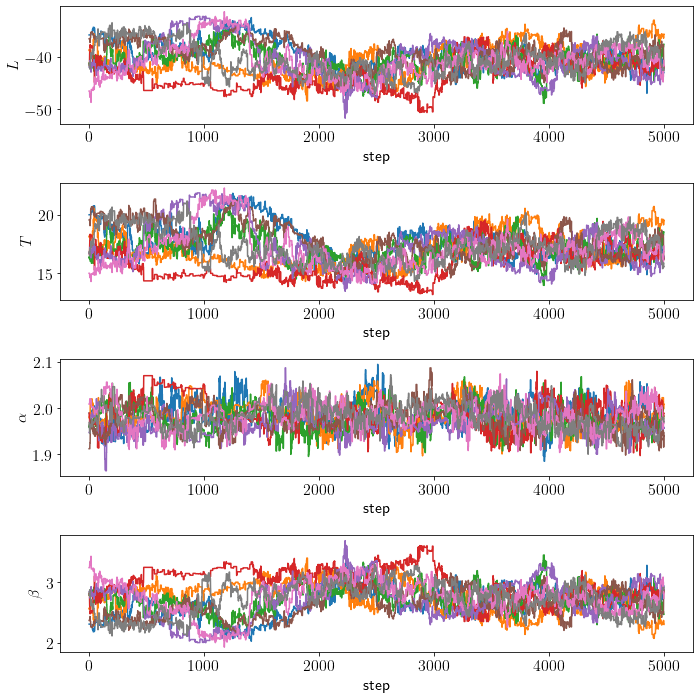

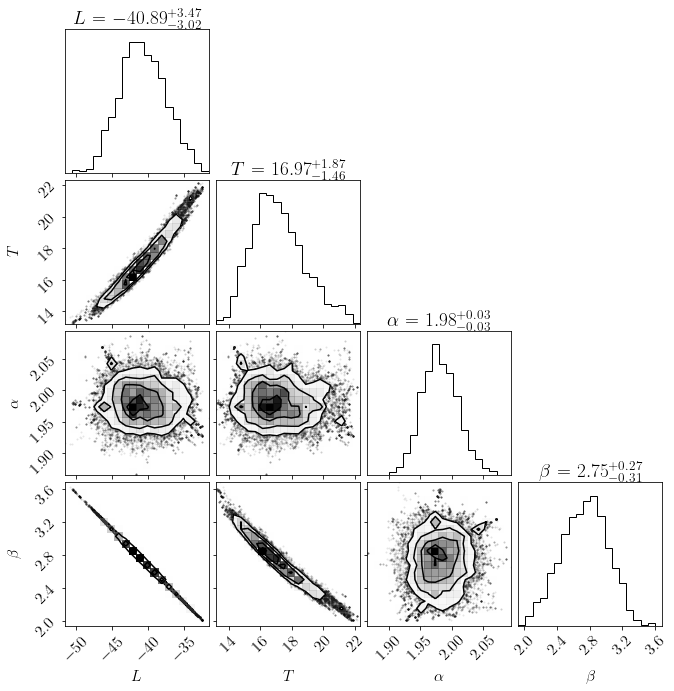

In [181]:
# Emcee run for NGC 0958 model

ndim = 4
nwalk = ndim*2
nburn = 2000
nmain = 5000

# Random starting points
p0 = np.zeros((nwalk, ndim))
for i in range(nwalk):
    p0[i] = fit + np.random.uniform(low=-0.05, high=0.05, size=4)

    
sampler = emcee.EnsembleSampler(nwalk, ndim, lnprob, args=(frequencies_NGC, flux_densities_NGC, errors_NGC))

# Burn-in run
pos,prob,state = sampler.run_mcmc(p0, nburn)

sampler.reset()

# Main run
res = sampler.run_mcmc(pos, nmain)
samples = sampler.chain.reshape((-1,ndim))

# plot the individual parameters for model
f, ax = plt.subplots(ndim, 1, figsize=(10, 10))
for idim in range(ndim):
    for iwalk in range(nwalk):
        ax[idim].plot(sampler.chain[iwalk,:,idim])
    ax[idim].set_xlabel('step')
ax[0].set_ylabel(r'$L$')
ax[1].set_ylabel(r'$T$')
ax[2].set_ylabel(r'$\alpha$')
ax[3].set_ylabel(r'$\beta$')
f.tight_layout()
f.show()

# Plot corner plot
f = corner.corner(samples, show_titles=True, labels=(r'$L$', r'$T$', r'$\alpha$', r'$\beta$'))
f.show()

# Subanalysis for different frequency values

### NGC 0958

[-40.41776409  20.48225975   4.97650191   2.69331186]


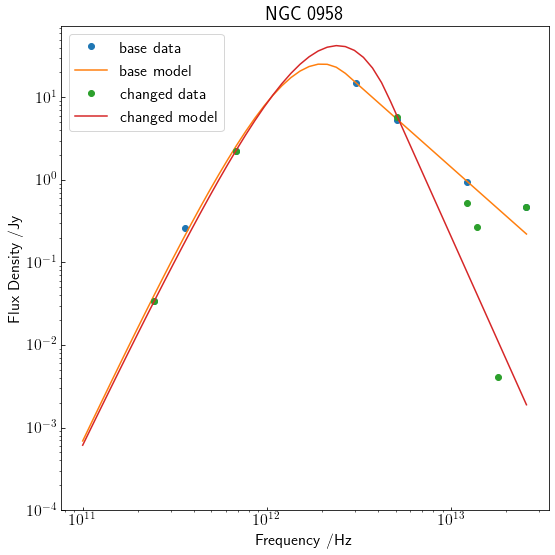

In [16]:
x1 = (1.019)*np.array([2.4e11, 6.66e11, 5e12, 1.2e13, 1.36e13, 1.76e13, 2.5e13])
y1 = np.array([0.034, 2.25, 5.85, 0.525, 0.27, 0.00416, 0.4735])
e1 = np.array( [0.007, 0.428, 0.04, 0.0379, 0.00224, 0.000233, 0.0616] )


fit1 = optimize.fmin(penalty, [-32, 28.8, 2.02, 1.5], args=(x1, y1, e1))
ngc_fit1 = model1(x1, fit1)
print (fit1)

x = np.logspace(11,13.41000)

f, ax = plt.subplots(1, figsize=(8,8))
ax.plot(frequencies_NGC, flux_densities_NGC, 'o', label=r'base data')
ax.plot(x, model1(x,fit), label=r'base model')
ax.plot(x1, y1, 'o', label= r'changed data')
ax.plot(x, model1(x,fit1),label=r'changed model')
ax.set_xscale('log')
ax.set_xticks([1e+11, 1e+12, 1e+13])
ax.set_yscale('log')
ax.set_yticks([0.0001, 0.001, 0.01, 0.1, 1, 10])
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.set_title('NGC 0958')
ax.set_ylabel('Flux Density /Jy')
ax.set_xlabel('Frequency /Hz')
ax.legend()
f.tight_layout()

<ipython-input-19-6746799ac227>:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
<ipython-input-19-6746799ac227>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


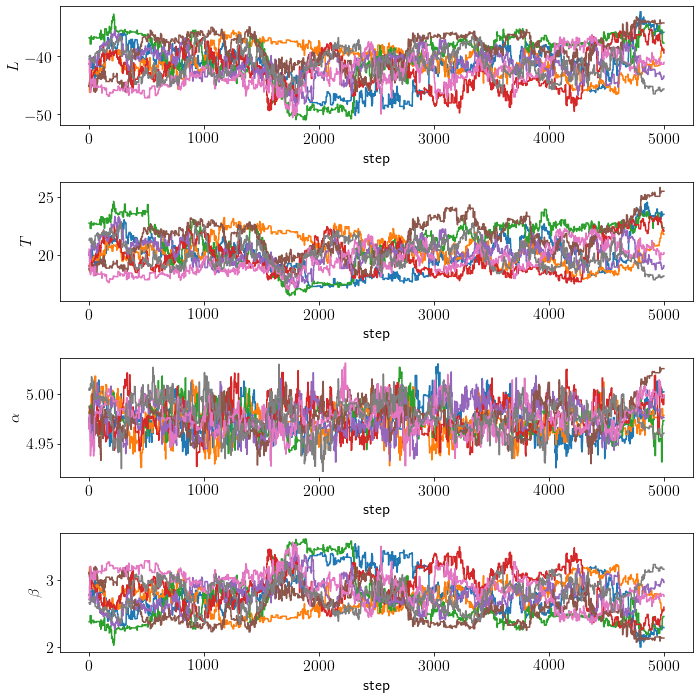

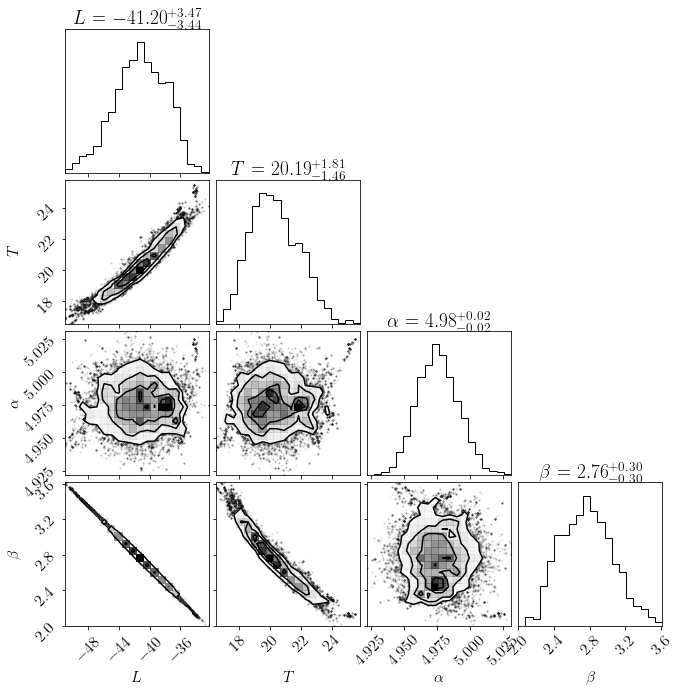

In [19]:
# Emcee run for NGC 0958 model

ndim = 4
nwalk = ndim*2
nburn = 2000
nmain = 5000

# Random starting points
p0 = np.zeros((nwalk, ndim))
for i in range(nwalk):
    p0[i] = fit + np.random.uniform(low=-0.05, high=0.05, size=4)

    
sampler = emcee.EnsembleSampler(nwalk, ndim, lnprob, args=(x1, y1, e1))

# Burn-in run
pos,prob,state = sampler.run_mcmc(p0, nburn)

sampler.reset()

# Main run
res = sampler.run_mcmc(pos, nmain)
samples = sampler.chain.reshape((-1,ndim))

# plot the individual parameters for model
f, ax = plt.subplots(ndim, 1, figsize=(10, 10))
for idim in range(ndim):
    for iwalk in range(nwalk):
        ax[idim].plot(sampler.chain[iwalk,:,idim])
    ax[idim].set_xlabel('step')
ax[0].set_ylabel(r'$L$')
ax[1].set_ylabel(r'$T$')
ax[2].set_ylabel(r'$\alpha$')
ax[3].set_ylabel(r'$\beta$')
f.tight_layout()
f.show()

# Plot corner plot
f = corner.corner(samples, show_titles=True, labels=(r'$L$', r'$T$', r'$\alpha$', r'$\beta$'))
f.show()